In [232]:
#########################
# 5-10 December 2021    #
# Tonale Winter School  #
# Marta Spinelli        #
#########################

In [418]:
#Python Notebook written by Marta Spinelli
#Acknowledgements: Isabella Carucci(PCA), Laura Wolz (FastICA) 

3$^{rd}$ PART

In [1]:
import numpy as np
import healpy as hp
from astropy.io import fits
import scipy.ndimage as ndimage
from sklearn.decomposition import FastICA
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def plot_patch(patch,label,title,extent):

    fig, ax = plt.subplots()
    norm=plt.Normalize(vmin=np.min(patch), vmax=np.max(patch))
    ax = plt.gca()
    im = ax.imshow(patch.T,extent=extent,norm=norm,origin='lower')
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax,label=label)


    ax.set_xlabel(r'${\rm R.A} (J2000) [^\circ]$',fontsize=15)
    ax.set_ylabel(r'${\rm Dec} (J2000) [^\circ]$',fontsize=15)
    fig.tight_layout()

Read in the mock data

In [4]:
mock21=np.load('output/final_mock21.npz')['mock21']
Nx=mock21.shape[0]
Ny=mock21.shape[1]
Nf=mock21.shape[2]
print(Nx,Ny,Nf)

151 51 100


In [5]:
ra=np.load('output/MK_footprint.npz')['ra']
dec=np.load('output/MK_footprint.npz')['dec']
ra_edges=np.load('output/MK_footprint.npz')['ra_edges']
dec_edges=np.load('output/MK_footprint.npz')['dec_edges']

#for plots
extent=[np.min(ra),np.max(ra),np.min(dec),np.max(dec)]

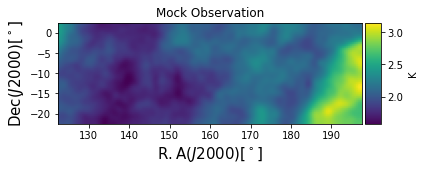

In [6]:
label='K'
title='Mock Observation'
plot_patch(mock21[:,:,0],label,title,extent)

In [8]:
freqs=np.load('output/final_mock21.npz')['freqs']

### We plot here what we would like to find

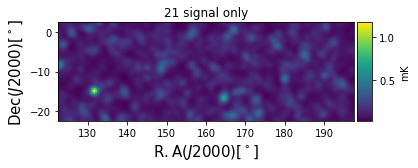

In [11]:
signal=np.load('output/sig_only.npz')['signal']
plot_patch(signal[:,:,10]*1e3,r'${\rm mK}$','21 signal only',extent)

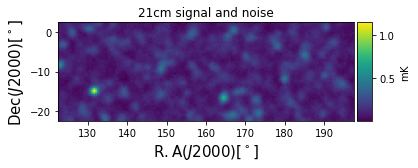

In [12]:
sig_noise=np.load('output/sig_noise.npz')['sig_noise']
plot_patch(sig_noise[:,:,10]*1e3,r'${\rm mK}$','21cm signal and noise',extent)

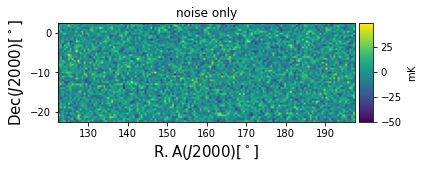

In [14]:
noise=np.load('output/noise_only.npz')['noise']
plot_patch(noise[:,:,10]*1e3,r'${\rm mK}$','noise only',extent)

# Foreground cleaning

## Let's have a look at the math implementing PCA

Flat the map in an array

In [15]:
# convert into array with NfreqxNpix
X=np.zeros((Nf,Nx*Ny))

for ff in range(Nf):
    X[ff,:]=mock21[:,:,ff].flatten()
    
print('X', X.shape)

X (100, 7701)


Compute the frequency-frequancy covariance matrix

In [16]:
C=np.dot(X,X.T)
print('C',C.shape)

C (100, 100)


Evaluate eigen values and eigenvectors

In [17]:
w, v = LA.eig(C)

How do the eigenvvalues behave? How many components should we subtract?

(1.0, 10.0)

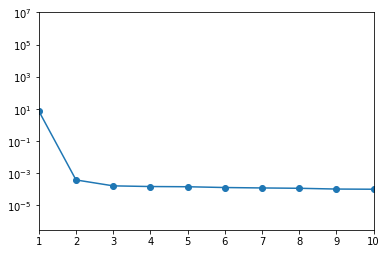

In [18]:
plt.plot(np.arange(len(w)),w,marker='o')
plt.yscale('log')
plt.xlim(1,10)

We choose 3 (with current real data 3 is surely not enough!)

In [19]:
NUM=3
Ah=v[:,0:NUM]
Ah.shape

(100, 3)

Ah ($\hat{\mathbf{A}}$) is the matrix composed by the first NUM eigenvector of $\mathbf{C}$

We now compute the projection of the selected eigenvectors along the data, obtaining the eigen-sources
$S=(\hat{\mathbf{A}}\mathbf{A}^{\rm T})^{-1}\mathbf{A}^{\rm T}\mathbf{X}$

In [20]:
piA=np.dot(LA.inv(np.dot(Ah.T,Ah)),Ah.T)
S=np.dot(piA,X)
print(S.shape)

(3, 7701)


### Visualize the component maps

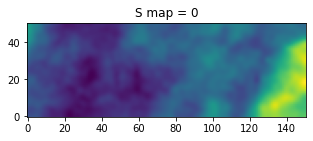

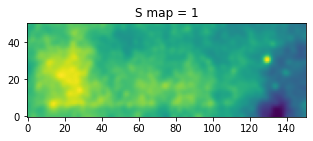

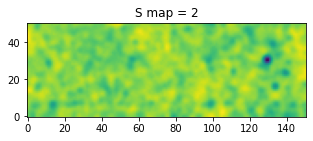

In [21]:
Compmap=np.zeros((NUM, Nx,Ny))
for j in range(0, NUM):
    plt.figure(figsize=(5,5))
    Compmap[j]=S[j,:].reshape((Nx,Ny), order="A")
    plt.imshow(Compmap[j].T, cmap="viridis",origin='lower')
    plt.title("S map = "+str(j))

Do you recognise similarity with the input components?

### Compute the residuals: the reconstructed HI signal!

In [22]:
res=X-np.dot(Ah,S)
res.shape

(100, 7701)

In [23]:
#Convert back into cube of (Nx,Ny,Nf)
RecHI_PCA=np.zeros((Nx,Ny,Nf))
for ff in range(Nf):
    RecHI_PCA[:,:,ff]=res[ff,:].reshape((Nx,Ny))

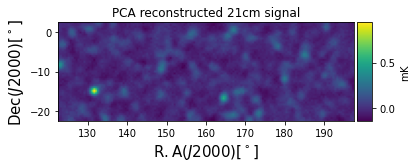

In [24]:
plot_patch(RecHI_PCA[:,:,10]*1e3,r'${\rm mK}$','PCA reconstructed 21cm signal',extent)

## Let's have a look at FastICA

Set number of modes to remove

In FastICA nomenclature is Indipendent Components (ICs)

In [25]:
NUM=3

In [29]:
## Set up fastICA
ica = FastICA(n_components=NUM, whiten=True)

# Reconstruct signals
S_ = ica.fit_transform(X.T)   #note the .T!

# Get estimated mixing matrix
A_ = ica.mixing_  


print("A" ,A_.shape)
print("S ", S_.shape)

A (100, 3)
S  (7701, 3)


In [32]:
#Reconstructed foreground
Recon_FG=np.dot(S_, A_.T)+ ica.mean_

print(len(Recon_FG[0]))

100


In [33]:
#Residual of fastICA should contain HI and noise
Residual=X.T-Recon_FG

#Convert back into cube of (Nx,Ny,Nf)
RecHI_FastICA=np.zeros((Nx,Ny,Nf))
for ff in range(Nf):
    RecHI_FastICA[:,:,ff]=Residual[:,ff].reshape((Nx,Ny))

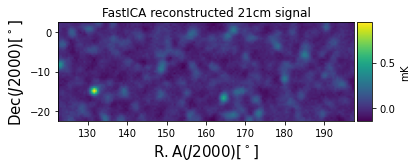

In [34]:
plot_patch(RecHI_FastICA[:,:,10]*1e3,r'${\rm mK}$','FastICA reconstructed 21cm signal',extent)

### We now do a quick evaluation of the LOS power spectrum

In [35]:
def pklos(patch):
    Nx,Ny,Nf=patch.shape
    kf=np.fft.fftfreq(Nf)
    Pk=np.zeros(Nf)
    for nx in range(Nx):
        for ny in range(Ny):
            Pk+=np.abs(np.fft.fftn(patch[nx,ny,:]))**2
    return kf, Pk/(Nx*Ny)

In [36]:
kf, Pko= pklos(sig_noise)
kf, Pks= pklos(signal)
kf, PkPCA=pklos(RecHI_PCA)
kf, PkFastICA=pklos(RecHI_FastICA)

Text(0.5, 1.0, 'NUM=3')

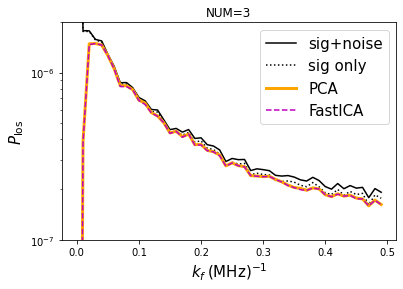

In [38]:
plt.plot(kf[:int(Nf/2)],Pko[:int(Nf/2)],label='sig+noise',color='k')
plt.plot(kf[:int(Nf/2)],Pks[:int(Nf/2)],label='sig only',color='k',linestyle=':')
plt.plot(kf[:int(Nf/2)],PkPCA[:int(Nf/2)],label='PCA',color='orange',linewidth=3.)
plt.plot(kf[:int(Nf/2)],PkFastICA[:int(Nf/2)],label='FastICA',color='m',linestyle='--')
plt.yscale('log')
plt.ylim(1e-7,2e-6)
plt.legend(fontsize=15)
plt.ylabel(r'$P_{\rm los}$',fontsize=15)
plt.xlabel(r'$k_f \: ({\rm MHz})^{-1}$',fontsize=15)
plt.title('NUM=3')